## 针对生成模型（自编码器AutoEncoder）的基于生成的对抗攻击

### 1、训练对抗扰动生成器

In [1]:
import torch
import torchvision
from net.advGenerator import ResnetGenerator
from tarmodel.AutoEncoder import Generator
from utils.data_loader import get_loader
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# 加载扰动生成器
advG = ResnetGenerator(input_nc=3).to(device)

# 加载目标AE模型
model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/AE_celeba.pth'))
model.eval()

# 读取数据
train_loader = get_loader("dataset/celeba/images", "dataset/celeba/list.txt", ['Black_Hair'], image_size=256, batch_size=16, shuffle=14, mode="train", num_workers=4)

Finished preprocessing the CelebA dataset...


In [2]:
from utils.gen_attack import Gen_Attack

# 初始化扰动生成器训练类
gen_attack = Gen_Attack(target_model=model, advGen=advG, device=device)

# 开始训练
# gen_attack.train(train_loader)

### 2、使用扰动生成器来生成对抗扰动攻击AutoEncoder

In [3]:
# 加载扰动生成器
advG = ResnetGenerator(input_nc=3).to(device)
advG.load_state_dict(torch.load('checkpoints/adv_gen.pth'))
advG.eval()


# 读取测试数据
testloader = get_loader("dataset/celeba/images", "dataset/celeba/list.txt", ['Black_Hair'], image_size=256, batch_size=5, mode="test", num_workers=1)

# 3. 获取一批图像和标签
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


# 生成对抗扰动
epsilon = 0.05
perturbation = advG(images)
perturbation = torch.clamp(perturbation, -epsilon, epsilon)
adv_images = torch.clamp(images + perturbation, -1.0, 1.0)

# 攻击AE
output = model(adv_images)

Finished preprocessing the CelebA dataset...


### 3、可视化对抗样本和攻击结果

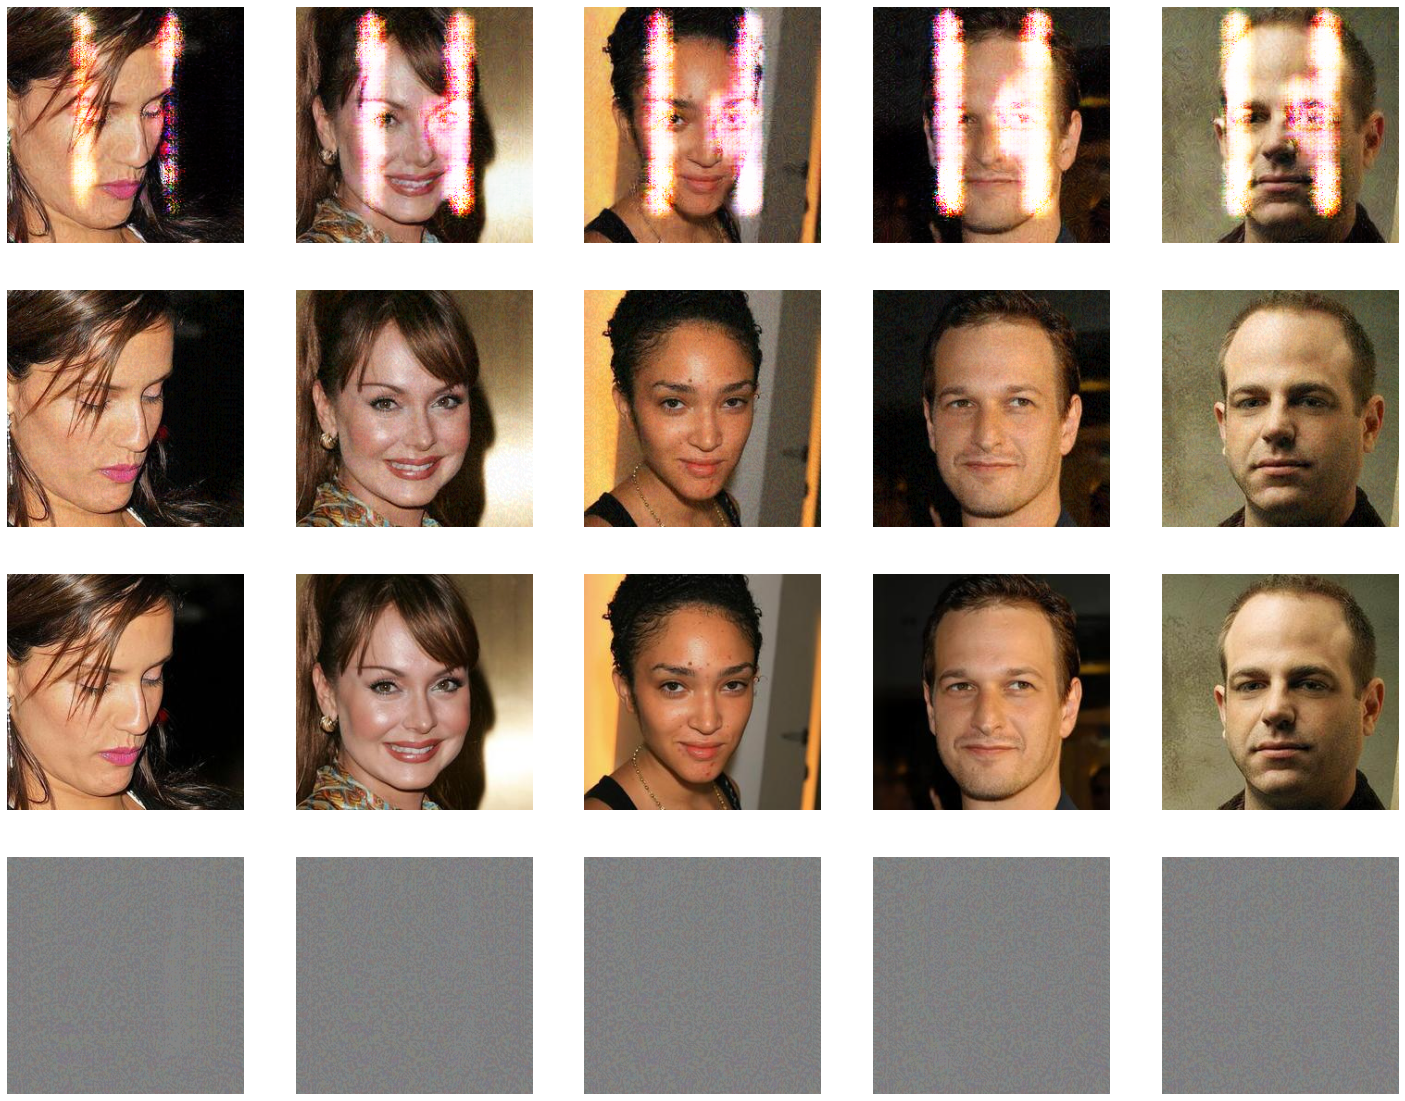

In [7]:
import matplotlib.pyplot as plt
from utils.utils import denorm

# 绘制图像
fig, axes = plt.subplots(4, 5, figsize=(25, 20)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    adv_img = denorm(adv_images)[i].detach().cpu().numpy().transpose((1, 2, 0))  
    img = denorm(images)[i].cpu().numpy().transpose((1, 2, 0))
    noise = denorm(perturbation)[i].detach().cpu().numpy().transpose((1, 2, 0))
    

    # 显示攻击结果
    axes[0, i].imshow(attack_res)
    axes[0, i].axis('off')

    # 显示对抗样本
    axes[1, i].imshow(adv_img)
    axes[1, i].axis('off')
    
    # 显示原始图像
    axes[2, i].imshow(img)
    axes[2, i].axis('off')

    # 显示对抗噪声
    axes[3, i].imshow(noise)
    axes[3, i].axis('off')

plt.show()